# 1 多分类
这个部分需要你实现手写数字（0到9）的识别。你需要扩展之前的逻辑回归，并将其应用于一对多的分类。

## 数据集
这是一个MATLAB格式的.mat文件，其中包含5000个20*20像素的手写字体图像，以及它对应的数字。
另外，数字0的y值，对应的是10
用Python读取我们需要使用SciPy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.metrics import classification_report # 这个包是评价报告

In [2]:
data = loadmat('E:\机器学习(吴恩达)\ML数据\ml_ex3\ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

## 1.2 数据可视化

随即展示100个数据

In [4]:
sample_idx = np.random.choice(np.arange(data['X'].shape[0]),100)
sample_images = data['X'][sample_idx, :]
sample_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

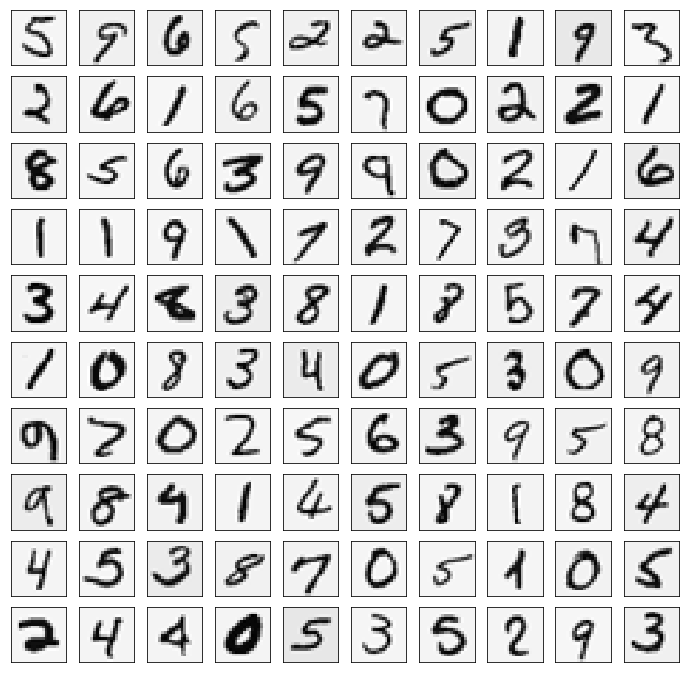

In [5]:
fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(12,12))
for r in range(10):
    for c in range(10):
        ax_array[r, c].matshow(np.array(sample_images[10 * r + c].reshape((20, 20))).T, cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

## 1.3 将逻辑回归向量化
你将用多分类逻辑回归做一个分类器。因为现在有10个数字类别，所以你需要训练10个不同的逻辑回归分类器。
87为了让训练效率更高，将逻辑回归向量化是非常重要的，不要用循环。

### 1.3.1 向量化代价函数

sigmoid函数

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
def cost(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 -y),np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:, 1:theta.shape[1]], 2))
    return np.sum(first - second) / len(X) + reg

### 1.3.2 向量化梯度

### 1.3.3 向量化正则化逻辑回归

In [8]:
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    error = sigmoid(X * theta.T) - y
    
    grad = ((X.T * error) / len(X)).T + ((learningRate / len(X)) * theta)
   
    # intercept gradient is not regularized
    grad[0, 0] = np.sum(np.multiply(error, X[:,0])) / len(X)
    
    return np.array(grad).ravel()

## 1.4 一对多分类器

现在我们已经定义了代价函数和梯度函数，现在是构建分类器的时候了。
对于这个任务，我们有10个可能的类，并且由于逻辑回归只能一次在2个类之间进行分类，我们需要多类分类的策略。
任务是实现一对一全分类方法，其中具有k个不同类的标签就有k个分类器，每个分类器在“类别 i”和“不是 i”之间决定。
我们将把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回为k*(n + 1)数组，其中n是参数数量。

In [9]:
from scipy.optimize import minimize

def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    
    # k * (n + 1) array for the parameters of each of the k classifiers
    all_theta = np.zeros((num_labels, params + 1))
    
    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    
    # labels are 1-indexed instead of 0-indexed
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = np.reshape(y_i, (rows, 1))
        
        # minimize the objective function
        fmin = minimize(fun=cost, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[i-1,:] = fmin.x
    
    return all_theta

In [10]:
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

In [11]:
np.unique(data['y'])#看下有几类标签

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [12]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta


array([[-2.38319441e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30442256e-03, -7.52260392e-10,  0.00000000e+00],
       [-3.18491754e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46097730e-03, -5.08608713e-04,  0.00000000e+00],
       [-4.79458561e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.86944532e-05, -2.47340048e-07,  0.00000000e+00],
       ...,
       [-7.98810652e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.94902619e-05,  7.21856618e-06,  0.00000000e+00],
       [-4.57271816e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33059832e-03,  9.95893529e-05,  0.00000000e+00],
       [-5.40510030e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16593193e-04,  7.88108976e-06,  0.00000000e+00]])